# EDA: Car Insurance Cold Calls

## Explore the data

The data set we will use for this exercise comes from the featured Kaggle datasets, containing data about cold calls to both existing and potential car insurance customers. The data provides some demographic data about each person called (customer), such as age, job, marital status and education, along with call details and some features indicating insurance status.

The goal here is to perform exploratory data analysis (EDA), using both visual EDA and some statistics and probability.

For statistics we will use the Chi-square test of independence, which is meant to be used with categorical data. In this case we will be concerned with the effects of some demographic features on the outcome of the calls.

## Exponential distributions
Exponential distributions have the probability density funtion

$$f(x; \lambda) = \begin{cases}
    \lambda e^{-\lambda x} &\text{ } x \geq 0\\
    0 &\text{ } x < 0
    \end{cases}$$

and cumulative density function

$$F(x; \lambda) = 1 - e^{-\lambda x}.$$

The expectation value (mean) is $\lambda^{-1}$ and percentiles can be computed using

$$F^{-1}(p; \lambda) = \frac{-ln(1-p)}{\lambda}$$

Where p is the desired percentile. Since we can easily compute the mean of our data, we can use that to get lamba and thus compute percentiles.

In our case, we can easily compute the mean of our data using pandas:

## Chi-square tests of independence

Chi-square tests are used to compare two categorical variables from a single population; they are used to determine if there is a significant associtation between them. The test has three requirements:

* The two variables being tested are categorical
* They data was acquired using simple random sampling
* The expected frequency count for each cell of a contingency table for the data is at least 5

For this set we will assume the second requirement has been met.

## Problems

1. Compute descriptive statistics for every feature in the data.
    - Create a columm for call duration. Test whether there is a signifiant relationship between call duration and having or not having insurance.
2. Plot a histogram of call durations using 25 bins. The call durations can be modeled using an exponential distribution. What is the expected value for call duration?
3. Estimate the exponential distribution and compute the mean, median, and the 95th percentile. Compare these values to those computed from the data.
    - What are these values for the two groups: has car insurance, and doesn't have car insurance?
4. Write a function to select only features that could be Bernoulli random variables and select one of them to
    - compute the probability that a random sample (n = 10) would contain exactly 3 successes
    - compute the probability that such a sample would contain at most 3 successes
5. Write a function to create a column that categorizes each age according to the following age ranges:
    - 18-24
    - 25-34
    - 35-44
    - 45-54
    - 55-64
    - 65+
6. Create a stacked bar chart showing the frequency of each age group. What are the most and least common groups? Now plot and describe the distribution of ages.
7. Create contingency tables for the following pairs:
    - Marital and Outcome
    - Education and Outcome
    - Job and Outcome
    - age_group and Outcome
8. Transform these contingency tables to show proportions of Outcome by each independent variable (Education, etc.). Plot these tables as heatmaps.
9. Run Chi-square tests for independence (alpha = 0.05) on all the contingency tables and interpret the results.
10. Which of these contingency tables are not appropriate for a Chi-square test? Why not?
    - Redo the tests using only "failure" and "success" outcomes, and interpret the results. Is the Job table still not appropriate for chi-square?

In [1]:
# Import data modules
import pandas as pd
from pandas import DataFrame as DF
from pandas import Series
import numpy as np

# Import stats modules
import scipy as scp
import scipy.stats as st

# Import plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting parameters
%matplotlib inline
sns.set_style('whitegrid')
gnbu = sns.color_palette('GnBu', 40)

In [2]:
# Read in data on car insurance cold calls
data = pd.read_csv('data/car_insurance.csv', parse_dates = ['CallStart', 'CallEnd'])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
Id                  4000 non-null int64
Age                 4000 non-null int64
Job                 3981 non-null object
Marital             4000 non-null object
Education           3831 non-null object
Default             4000 non-null int64
Balance             4000 non-null int64
HHInsurance         4000 non-null int64
CarLoan             4000 non-null int64
Communication       3098 non-null object
LastContactDay      4000 non-null int64
LastContactMonth    4000 non-null object
NoOfContacts        4000 non-null int64
DaysPassed          4000 non-null int64
PrevAttempts        4000 non-null int64
Outcome             958 non-null object
CallStart           4000 non-null datetime64[ns]
CallEnd             4000 non-null datetime64[ns]
CarInsurance        4000 non-null int64
dtypes: datetime64[ns](2), int64(11), object(6)
memory usage: 593.8+ KB


## 1. Compute descriptive statistics for every feature in the data

In [4]:
# Describe numeric data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,4000.0,2000.50000,1154.844867,1.0,1000.75,2000.5,3000.25,4000.0
Age,4000.0,41.21475,11.550194,18.0,32.00,39.0,49.00,95.0
Default,4000.0,0.01450,0.119555,0.0,0.00,0.0,0.00,1.0
Balance,4000.0,1532.93725,3511.452489,-3058.0,111.00,551.5,1619.00,98417.0
HHInsurance,4000.0,0.49275,0.500010,0.0,0.00,0.0,1.00,1.0
CarLoan,4000.0,0.13300,0.339617,0.0,0.00,0.0,0.00,1.0
LastContactDay,4000.0,15.72125,8.425307,1.0,8.00,16.0,22.00,31.0
NoOfContacts,4000.0,2.60725,3.064204,1.0,1.00,2.0,3.00,43.0
DaysPassed,4000.0,48.70650,106.685385,-1.0,-1.00,-1.0,-1.00,854.0
PrevAttempts,4000.0,0.71750,2.078647,0.0,0.00,0.0,0.00,58.0


In [5]:
# Describe categorical data
data.describe(include = ['O']).T

,count,unique,top,freq
Job,3981,11,management,893
Marital,4000,3,married,2304
Education,3831,3,secondary,1988
Communication,3098,2,cellular,2831
LastContactMonth,4000,12,may,1049
Outcome,958,3,failure,437


In [6]:
# Describe datetime data
data.describe(include = ['datetime']).T

,count,unique,top,freq,first,last
CallStart,4000,3777,2017-10-15 11:48:25,3,2017-10-15 09:00:00,2017-10-15 17:59:58
CallEnd,4000,3764,2017-10-15 10:22:30,3,2017-10-15 09:02:20,2017-10-15 18:25:31


## Create call_duration column

In [7]:
# Call duration in minutes
data['call_minutes'] = [round(tdelt.seconds/60, 2) for tdelt in (data.CallEnd - data.CallStart)]

### Compute t-test of difference in duration of calls for those 'With' and 'Without' Car Insurance

In [8]:
# Examine differences of durations in calls of those with (1) and without (0) car insurance
data.groupby('CarInsurance').call_minutes.describe(percentiles = [0.95])

,count,mean,std,min,50%,95%,max
CarInsurance,,,,,,,
0,2396.0,3.605972,3.437081,0.08,2.62,9.7075,50.42
1,1604.0,9.195611,6.692222,0.42,7.45,22.3925,54.22


In [9]:
# Compute t-test of differences without assuming equal variance
without_insurance = data[data['CarInsurance'] == 0].call_minutes
with_insurance = data[data['CarInsurance'] == 1].call_minutes
st.ttest_ind(without_insurance, with_insurance, equal_var = False)

Ttest_indResult(statistic=-30.839243773088487, pvalue=1.5294159768572273e-173)

The p-value < 0.05 indicates that those without car insurance are statistically more likely to have longer call durations than those who are already insured.

## 2. a) Plot a histogram of call durations using 25 bins

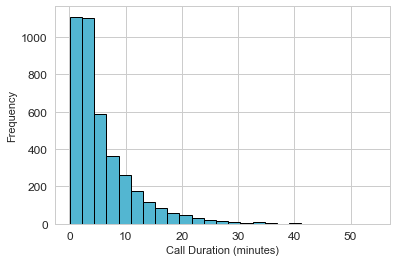

In [10]:
ax = data.call_minutes.plot.hist(bins = 25, lw = 1, color = gnbu[24], edgecolor = 'k', fontsize = 12)
ax.set_xlabel('Call Duration (minutes)');

## 2. b) Expected Call Duration

In [11]:
# Expeced value ==  mean of the data
call_mean = data.call_minutes.mean()
call_mean

5.847417500000034

## 3. Estimate the exponential distribution and compute the mean, median, and the 95th percentile

### Compute components of distribution

In [12]:
call_lambda = 1 / call_mean
call_lambda

0.1710156663176512

In [13]:
median = -np.log(1 - 0.5) / call_lambda
median

4.0531209536819075

In [14]:
percentile95 = -np.log(1 - 0.95) / call_lambda
percentile95

17.517297321694489

In [15]:
variance = 1 / (call_lambda ** 2)
variance

34.19229141930665

In [16]:
stdev = np.sqrt(variance)
stdev

5.8474175000000344

### Describe using Pandas tools

In [17]:
data.call_minutes.describe(percentiles = [0.95])

count    4000.000000
mean        5.847418
std         5.703876
min         0.080000
50%         3.870000
95%        17.633500
max        54.220000
Name: call_minutes, dtype: float64

Since the computed values are close to those 

### What are these values for the two groups: has car insurance, and doesn't have car insurance?

In [18]:
call_means = data.groupby('CarInsurance').call_minutes.mean()
call_means

CarInsurance
0    3.605972
1    9.195611
Name: call_minutes, dtype: float64

In [19]:
call_lambdas = 1 / call_means
call_lambdas

CarInsurance
0    0.277318
1    0.108748
Name: call_minutes, dtype: float64

In [20]:
medians = -np.log(1 - 0.5) / call_lambdas
medians

CarInsurance
0    2.499470
1    6.373912
Name: call_minutes, dtype: float64

In [21]:
percentile95s = -np.log(1 - 0.95) / call_lambdas
percentile95s

CarInsurance
0    10.802528
1    27.547589
Name: call_minutes, dtype: float64

In [22]:
variances = 1 / (call_lambdas ** 2)
variances

CarInsurance
0    13.003037
1    84.559261
Name: call_minutes, dtype: float64

In [23]:
stdevs = np.sqrt(variances)
stdevs

CarInsurance
0    3.605972
1    9.195611
Name: call_minutes, dtype: float64

In [24]:
data.groupby('CarInsurance').call_minutes.describe(percentiles = [0.95])[['50%', '95%', 'std']]

,50%,95%,std
CarInsurance,,,
0,2.62,9.7075,3.437081
1,7.45,22.3925,6.692222


The data remains close to an exponential distribution after accounting for the car insurance variable, but not as close in its absence.

## 4. Write a function to select only features that could be binomial random variables and select one of them to
* compute the probability that a random sample (n = 10) would contain exactly 3 successes
* compute the probability that such a sample would contain at most 3 successes

### Write a function to select only features that could be binomial random variables

In [25]:
# A function that returns a list of names for columns that contain only the values 0 and 1
def get_binomial(data):
    binom = []
    for col in data:
        # Create set of unique values in col
        s1 = set(data[col].unique())
        # Binary set for comparison
        s2 = {0, 1}
        # Get the intersection and union of the two sets
        ix = s1.intersection(s2)
        un = s1.union(s2)
        # If the intersection and union are equal, the col contains only binary values
        if ix == un:
            # Keep if binary
            binom.append(col)
    return binom

In [26]:
binomial_cols = get_binomial(data)
data[binomial_cols].head()

,Default,HHInsurance,CarLoan,CarInsurance
0,0,1,0,0
1,0,1,0,0
2,0,1,0,1
3,0,1,0,1
4,0,0,0,0


### Compute P(X = 3)

In [27]:
# P(X = 3)
p = data.CarInsurance.mean()
p_eq_3 = scp.misc.comb(10, 3) * p**3 * (1 - p)**7
p_eq_3

0.2140928288566627

### Compute P(X &leq; 3)

In [28]:
# A fuction that returns the cumulative distribution for binomial random variables: P(X <= k)
def bsum(ki, kf):
    """ ki : initial k
        kf : final k
    """
    prob = 0
    for k in range(ki, kf + 1):
        prob += scp.misc.comb(10, k) * p**k * (1 - p)**(10 - k)
    return prob

In [29]:
# P(X <= 3)
p_lteq_3 = bsum(0, 3)
p_lteq_3

0.3797755224858258

* Alternative: scipy.stats.binom.pmf or scipy.stats.binom.cdf

In [30]:
# probability mass and cumulative distribution functions
st.binom.pmf(3, 10, p), st.binom.cdf(3, 10, p)

(0.21409282885666275, 0.37977552248582586)

## 5. Write a function to create a column that categorizes each age according to the following age ranges:
    - 18-24
    - 25-34
    - 35-44
    - 45-54
    - 55-64
    - 65+

In [31]:
# Function to add age ranges to data set
def cat_ages(x):
    if x in range(18, 25):
        return '18-24'
    elif x in range(25, 35):
        return '25-34'
    elif x in range(35, 45):
        return '35-44'
    elif x in range(45, 55):
        return '45-54'
    elif x in range(55, 65):
        return '55-64'
    else:
        return '65+'

In [32]:
data['age_group'] = data.Age.apply(lambda x: cat_ages(x))

## 6. Create a stacked bar chart showing the frequency of each age group. What are the most and least common groups?

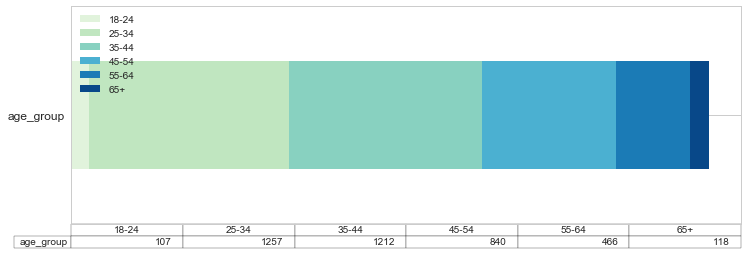

In [33]:
age_df = DF(data.age_group.value_counts().sort_index()).T
ax = age_df.plot.barh(table = age_df, stacked = True, figsize = (12, 4), color = gnbu[4::7], fontsize = 12)
ax.legend(loc = 2)
ax.get_xaxis().set_visible(False);

* Most common: '25-34' (closely followed by '35-44')
* Least common: '18-24' (closely followed by '65+')

### Now plot and describe the distribution of ages

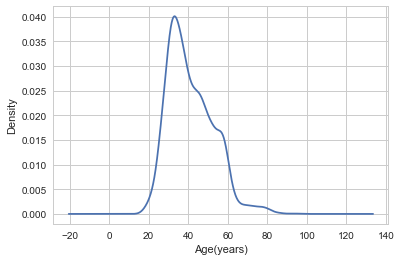

In [34]:
# Kernel density estimate (KDE) plot
ax = data.Age.plot.kde()
ax.set_xlabel('Age(years)');

The distribution has an overall Gaussian shape, with a right skew and rough modality on the right edge.

## 7. Create contingency tables for the following pairs:
    - Education and Outcome
    - CarInsurance and Outcome
    - Job and Outcome
    - age_group and Outcome

In [35]:
# Function to create contingency tables
def contingencies(data, feats):
    tables = {}
    for f in feats:
        tables[f] = pd.crosstab(data[f], data.Outcome)
    return tables

In [36]:
feats = ['Education', 'CarInsurance', 'Job', 'age_group']
tables = contingencies(data, feats)

In [37]:
# Education and outcome
tables['Education']

Outcome,failure,other,success
Education,,,
primary,50,28,24
secondary,223,95,147
tertiary,148,63,137


In [38]:
# CarInsurance and outcome
tables['CarInsurance']

Outcome,failure,other,success
CarInsurance,,,
0,261,103,35
1,176,92,291


In [39]:
# Job and outcome
tables['Job']

Outcome,failure,other,success
Job,,,
admin.,56,31,33
blue-collar,76,27,33
entrepreneur,13,1,2
housemaid,9,4,2
management,108,43,94
retired,16,11,43
self-employed,9,8,11
services,38,11,22
student,15,15,18


In [40]:
# age_group and outcome
tables['age_group']

Outcome,failure,other,success
age_group,,,
18-24,7,8,15
25-34,163,69,87
35-44,134,66,88
45-54,77,30,55
55-64,45,15,54
65+,11,7,27


## 8. Transform these contingency tables to show proportions of Outcome by each independent variable (Education, etc.). Plot these tables as heatmaps.

In [41]:
# Use a loop to create a dictionary containing the various contingency tables with keys as feature names
tables_p = {}
for k in tables.keys():
    tp = tables[k].divide(tables[k].sum(axis = 1), axis = 0)
    tables_p[k] = tp

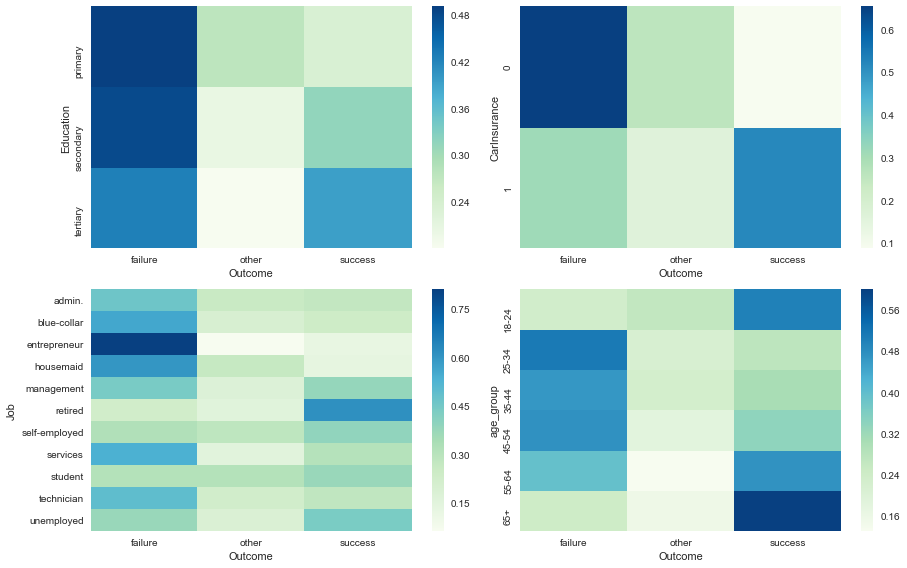

In [42]:
fig, ax = plt.subplots(2, 2, figsize = (13, 8))
for i, k in enumerate(tables_p.keys()):
    row = i//2 # set axes row number
    col = i%2 # set axes column number
    sns.heatmap(tables_p[k], cmap = 'GnBu', ax = ax[row, col])
plt.tight_layout()

Failures are most likely among entrepreneurs amd those already lacking car insurance.  Interestingly, failures increase with lack of education. The success rate is highest among the under 18-24 group, and progressively increase again with age.

## 9. Run Chi-square tests for independence (alpha = 0.05) on all the contingency tables and interpret the results.

In [43]:
for k in tables.keys():
    test = st.chi2_contingency(tables[k])
    print(k, '\n')
    print('p-value: {}'.format(test[1]))
    print('expected freqs:\n{}\n\n'.format(test[-1]))

Education 

p-value: 0.01770560632721026
expected freqs:
[[  46.93114754   20.73442623   34.33442623]
 [ 213.95081967   94.52459016  156.52459016]
 [ 160.11803279   70.74098361  117.14098361]]


CarInsurance 

p-value: 1.7043975659567056e-43
expected freqs:
[[ 182.00730689   81.21607516  135.77661795]
 [ 254.99269311  113.78392484  190.22338205]]


Job 

p-value: 3.756586383837732e-06
expected freqs:
[[  54.77439664   24.55403987   40.67156348]
 [  62.07764953   27.82791186   46.09443861]
 [   7.30325289    3.27387198    5.42287513]
 [   6.84679958    3.06925498    5.08394544]
 [ 111.83105981   50.13116474   83.03777545]
 [  31.95173137   14.32318993   23.7250787 ]
 [  12.78069255    5.72927597    9.49003148]
 [  32.40818468   14.52780693   24.06400839]
 [  21.90975866    9.82161595   16.26862539]
 [  71.20671563   31.92025184   52.87303253]
 [  21.90975866    9.82161595   16.26862539]]


age_group 

p-value: 2.7600837200876502e-05
expected freqs:
[[  13.68475992    6.10647182   10.208

* Education: p < 0.05; reject null hypothesis
* CarInsurance: p << 0.05; reject null hypothesis
* Job: p << 0.05; reject null hypothesis
* age_group: p << 0.05; reject null hypothesis

Each factor has a non-significant p-value, suggesting that it may have an impact on the success rate of the cold calls. Further analysis will be necessary to confirm, both the result and the appropriateness of the data for the Chi-square test (below).

## 10. Which of these contingency tables are not appropriate for a Chi-square test? Why not?

* Answer: (Job, Outcome)
* Some Jobs have expected frequencies fewer than 5, which fails the criteria for the Chi-square test.

### Redo the tests using only "failure" and "success" outcomes, and interpret the results. Is the Job table still not appropriate for chi-square?

In [44]:
filt = data[data.Outcome.isin(['failure', 'success'])]
tables = contingencies(filt, feats)

In [45]:
for k in tables.keys():
    test = st.chi2_contingency(tables[k])
    print(k, '\n')
    print('p-value: {}'.format(test[1]))
    print('expected freqs:\n{}\n\n'.format(test[-1]))

Education 

p-value: 0.01980955835179212
expected freqs:
[[  42.73525377   31.26474623]
 [ 213.67626886  156.32373114]
 [ 164.58847737  120.41152263]]


CarInsurance 

p-value: 1.702502133306324e-42
expected freqs:
[[ 169.53079948  126.46920052]
 [ 267.46920052  199.53079948]]


Job 

p-value: 8.659955443189096e-07
expected freqs:
[[  51.07519789   37.92480211]
 [  62.55277045   46.44722955]
 [   8.60817942    6.39182058]
 [   6.31266491    4.68733509]
 [ 115.92348285   86.07651715]
 [  33.85883905   25.14116095]
 [  11.47757256    8.52242744]
 [  34.43271768   25.56728232]
 [  18.93799472   14.06200528]
 [  69.43931398   51.56068602]
 [  22.38126649   16.61873351]]


age_group 

p-value: 8.246322717266391e-06
expected freqs:
[[  12.60026212    9.39973788]
 [ 143.18479685  106.81520315]
 [ 127.14809961   94.85190039]
 [  75.60157274   56.39842726]
 [  56.70117955   42.29882045]
 [  21.76408912   16.23591088]]




* Education: p < 0.05; reject null hypothesis
* CarInsurance: p << 0.05; reject null hypothesis
* Job: Contains expected frequency < 5 (Chi-square test invalid) 
* age_group: p << 0.05; reject null hypothesis

Filtering on success/failure did not bring all expected values in the 'Job' cells up beyond the threshold criterion for Chi-square testing.

# EDA: Flight Cancellations & Delays

## Explore the data

This data set comes from the featured Kaggle datasets, containing three tables that relate to commercial airline flights. The flight delay and cancellation data was collected and published by the DOT's Bureau of Transportation Statistics.

**There are three tables:**

* airlines : contains airline IATA codes with corresponding airline names
* airports : contains
    IATA_CODE:
    Location Identifier
    String

    AIRPORT:
    Airport's Name
    String

    CITY:
    City Name of the Airport
    String

    STATE:
    State Name of the Airport
    String

    COUNTRY:
    Country Name of the Airport
    String

    LATITUDE:
    Latitude of the Airport
    Numeric

    LONGITUDE:
    Longitude of the Airport
    Numeric
* flights : contains many features with descriptions that can be found [here](https://www.kaggle.com/usdot/flight-delays), by selecting flights.csv in the data and clicking on Edit descriptions above the data preview.

We cleaned this data in the cleaning notebook, and recall the mention that we started with a sample of the full set available on Kaggle, in order to reduce processing times.

## Possion distributions / Poisson process
The Poisson distribution represents the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known average rate and independently of the time since the last event. This comment about independence is actually referring to the memoryless property of the exponential distribution (a distribtuion introduced earlier). Put another way, the Poisson distribution represents a process of a series of events that each follow the same exponential distribution.

The Poisson probability formula:

$$P(x; \mu) = e^{-\mu}\frac{\mu^{x}}{x!}$$

where $x$ is the number of successes and $\mu$ is the mean of the distribution.

## Logarithmic transformations

Log transformations can be useful for a number of reasons; two reasons include scaling data for easier interpretation or transforming data to fit a distribution that can be modeled (e.g. making exponential data linear).

Example (notice how x-values beyond 10 are off the charts, but ln(x) is at visible scales out to 1000 and beyond):

![](images/loglin.png)

## Problems

1. Use pandas `apply()` method to create a table that contains the following stats for each airline:
    * flight volume (frequency in the data for each airline)
    * flight proportion (proportion of activity for all airlines)
    * diverted rate
    * cancelled rate
2. Compute the volume of activity by airport and airline/airport pairs and do the following:
    - Visualize volume by airline, airport, and airline/airport pairs
        + use airline names instead of IATA codes
    - Which airline has the highest volume overall? Which airport is the busiest for that airline?
3. Determine expected times between cancellations for an airline of your choosing.
    - Create a table that shows expected time between cancellations, number of cancellations, and number of records per airport.
    - Compute and create a table that shows the expected time between cancellations for this airline by month for the top 10 airports. Create a visual for this.
4. Model the time between cancellations as a Poisson distribution
    - For the Delta Air data for BOS airport in month 5 (May), compute the probability of the expected time between cancellation exceeding 5.
5. Is there a significant difference between the three most active airlines for overall cancellation rates?
6. Show the relationship between travel routes (origin -> destination) and diversion rates for Delta Air and the top 10 airports from earlier
7. Create and fill a column for mean ground speed for every flight in miles/hour
    - Do any of these seem unusual?
    - (distance column is in miles)
8. Create a visual for the mean times of delay reasons for each airline. Create one for delay proportions for each airline.
9. Plot the delay reasons by airline using a parallel coordinates plot
    - this can take a while so use a random sample of 10% of the data

In [46]:
# Import data modules
import pandas as pd
from pandas import DataFrame as DF
from pandas import Series
import numpy as np

# Import stats modules
import scipy as scp
import scipy.stats as st

# Import plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting parameters
%matplotlib inline
sns.set_style('whitegrid')
gnbu = sns.color_palette('GnBu', 40)

In [47]:
# Define columns which will contain datetime information
time_cols = ['scheduled_departure', 'departure_time', 'wheels_off', 'wheels_on', 'scheduled_arrival', 'arrival_time']

In [48]:
# Read data
airlines = pd.read_csv('data/airlines_cleaned.csv')
airports = pd.read_csv('data/airports_cleaned.csv')
flights = pd.read_csv('data/flights_cleaned_sm.csv', parse_dates = time_cols)

In [49]:
# Examine airlines
airlines

,iata_code,airline
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [50]:
# Examine airports
airports.head()

,iata_code,airport,city,state,country,latitude,longitude
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [51]:
# Examine flights
flights.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,...,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
0,2015,2,26,4,MQ,3264,N630MQ,DFW,MHK,2015-02-26 21:15:00,...,2015-02-26 00:37:00,120.0,0,0,NaN,2.0,0.0,118.0,0.0,0.0
1,2015,11,9,1,AA,1846,N801AW,DCA,TPA,2015-11-09 11:30:00,...,2015-11-09 13:46:00,1430.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,9,4,5,DL,1140,N320US,ATL,MSY,2015-09-04 22:50:00,...,2015-09-04 23:14:00,1435.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,5,4,1,WN,304,N361SW,SEA,OAK,2015-05-04 10:55:00,...,2015-05-04 13:23:00,28.0,0,0,NaN,9.0,0.0,1.0,18.0,0.0
4,2015,4,10,5,OO,5318,N919SW,CMX,ORD,2015-04-10 05:50:00,...,NaT,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN


In [52]:
# Examine flights data information
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611571 entries, 0 to 611570
Data columns (total 31 columns):
year                   611571 non-null int64
month                  611571 non-null int64
day                    611571 non-null int64
day_of_week            611571 non-null int64
airline                611571 non-null object
flight_number          611571 non-null int64
tail_number            597204 non-null object
origin_airport         611571 non-null object
destination_airport    611571 non-null object
scheduled_departure    611571 non-null datetime64[ns]
departure_time         527757 non-null datetime64[ns]
departure_delay        527757 non-null float64
taxi_out               524959 non-null float64
wheels_off             524959 non-null datetime64[ns]
scheduled_time         611566 non-null float64
elapsed_time           522965 non-null float64
air_time               524141 non-null float64
distance               611571 non-null int64
wheels_on              524141 non-null

In [53]:
# Describe numeric flights data
flights.describe().T

,count,mean,std,min,25%,50%,75%,max
year,611571.0,2015.000000,0.000000,2015.0,2015.0,2015.0,2015.0,2015.0
month,611571.0,6.045653,3.431623,1.0,3.0,6.0,9.0,12.0
day,611571.0,15.650147,8.844071,1.0,8.0,16.0,23.0,31.0
day_of_week,611571.0,3.872852,2.016334,1.0,2.0,4.0,6.0,7.0
flight_number,611571.0,2246.140348,1775.639749,1.0,760.0,1760.0,3387.0,9855.0
departure_delay,527757.0,10.069862,38.075967,-45.0,-5.0,-1.0,8.0,1475.0
taxi_out,524959.0,16.084542,8.929294,1.0,11.0,14.0,19.0,185.0
scheduled_time,611566.0,139.522158,74.139686,18.0,85.0,120.0,170.0,718.0
elapsed_time,522965.0,137.050688,74.257971,15.0,82.0,118.0,168.0,718.0
air_time,524141.0,141.546807,202.911192,0.0,55.0,89.0,147.0,1439.0


In [54]:
# Describe categorical flights data
flights.describe(include = ['O']).T

,count,unique,top,freq
airline,611571,14,WN,130241
tail_number,597204,4812,N493HA,388
origin_airport,611571,322,ATL,36853
destination_airport,611571,322,ATL,36951
cancellation_reason,87430,4,B,47874


In [55]:
# Describe datetime flights data
flights.describe(include = ['datetime']).T

,count,unique,top,freq,first,last
scheduled_departure,611571,190821,2015-02-02 06:00:00,133,2015-01-01 00:30:00,2015-12-31 23:59:00
departure_time,527757,273823,2015-04-23 05:56:00,14,2015-01-01 00:08:00,2015-12-31 23:57:00
wheels_off,524959,276180,2015-09-11 10:25:00,10,2015-01-01 00:05:00,2015-12-31 23:58:00
wheels_on,524141,282443,2015-12-29 14:03:00,9,2015-01-01 00:01:00,2015-12-31 23:59:00
scheduled_arrival,611571,265974,2015-02-25 20:00:00,24,2015-01-01 00:02:00,2015-12-31 23:59:00
arrival_time,524141,280956,2015-04-15 17:28:00,10,2015-01-01 00:01:00,2015-12-31 23:58:00


## 1. Use pandas `apply()` method to create a table that contains the following stats for each airline:
* flight volume (frequency in the data for each airline)
* flight proportion (proportion of activity for all airlines)
* diverted rate
* cancelled rate

In [56]:
airline_stats = flights.groupby('airline').apply(lambda x: Series({'flight_vol': x['airline'].count(),
                                                                   'flight_prop': x['airline'].count() / len(flights),
                                                                   'diverted_rate': x['diverted'].mean(),
                                                                   'cancel_rate': x['cancelled'].mean()}))

In [57]:
airline_stats

,cancel_rate,diverted_rate,flight_prop,flight_vol
airline,,,,
AA,0.137234,0.002302,0.121461,74282.0
AS,0.039354,0.001609,0.026425,16161.0
B6,0.147032,0.002482,0.046107,28198.0
DL,0.045687,0.002052,0.136252,83328.0
EV,0.223993,0.002353,0.107703,65868.0
F9,0.065410,0.000908,0.014399,8806.0
HA,0.022210,0.000978,0.011706,7159.0
MQ,0.365076,0.001336,0.066072,40408.0
NK,0.154378,0.000874,0.020580,12586.0


## 2. Compute the volume of activity by airport and airline/airport pairs and do the following:
- Visualize volume by airline, airport, and airline/airport pairs
    + use airline names instead of IATA codes
- Which airline has the highest volume overall? Which airport is the busiest for that airline?

In [58]:
# Compute airport volume
airport_vol = flights.groupby('origin_airport').size()

# Compute airline/airport pair volume
airline_airport_vol = pd.crosstab(flights.origin_airport, flights.airline).fillna(0)

In [59]:
airline_airport_vol

airline,AA,AS,B6,DL,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
origin_airport,,,,,,,,,,,,,,
ABE,0,0,0,36,231,0,0,0,0,4,0,0,0,0
ABI,0,0,0,0,0,0,0,332,0,0,0,0,0,0
ABQ,239,32,29,107,48,0,0,67,0,406,33,3,0,1179
ABR,0,0,0,0,0,0,0,0,0,72,0,0,0,0
ABY,0,0,0,0,92,0,0,0,0,0,0,0,0,0
ACK,0,0,55,0,0,0,0,0,0,0,0,0,0,0
ACT,0,0,0,0,115,0,0,94,0,0,0,0,0,0
ACV,0,0,0,0,0,0,0,0,0,171,0,0,0,0
ACY,0,0,0,0,0,0,0,0,399,0,0,0,0,0


## Visualize

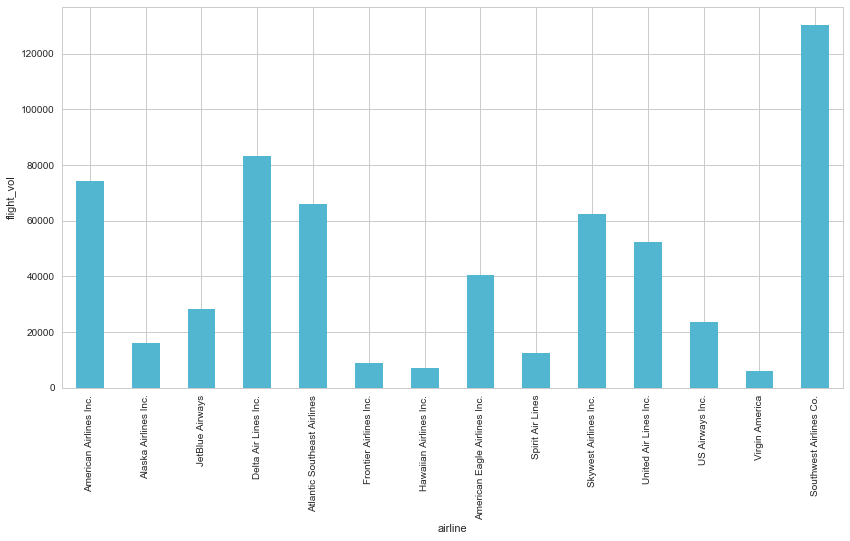

In [60]:
# Merge to get airline names
airline_stats_names = airline_stats.merge(airlines, left_index = True, right_on = 'iata_code').\
    set_index('airline', drop = True)
    
# Create bar chart
ax = airline_stats_names.flight_vol.plot.bar(color = gnbu[24:25], figsize = (14, 7))

# Set label for y-axis
ax.set(ylabel = 'flight_vol');

Southwest Airlines Co. has the highest overall volume.

## What airport was busiest for Southwest Airlines Co.?

In [61]:
max_airport = airline_airport_vol['WN'].idxmax()
max_airport_name = airports[airports.iata_code == max_airport].airport.values
max_vol = airline_airport_vol.loc[max_airport, 'WN']
print('Max Airport : {} {}\nVolume : {}'.format(max_airport, max_airport_name, max_vol))

Max Airport : MDW ['Chicago Midway International Airport']
Volume : 9356


## 3. Determine expected times between cancellations for an airline of your choosing.
- Create a table that shows expected time between cancellations, number of cancellations, and number of records per airport.
- Compute and create a table that shows the expected time between cancellations for this airline by month for the top 10 airports. Create a visual for this.

### Expected time between cancellations for Delta Airlines

In [62]:
delta_airports = airline_airport_vol[airline_airport_vol.DL > 0].index
delta_flights = flights[(flights.airline == 'DL') &
                        (flights.origin_airport.isin(delta_airports))].sort_values(by = 'scheduled_departure')

In [63]:
mean_times = delta_flights.groupby('origin_airport')\
    .apply(lambda x: Series({'mean_hours': ((x['scheduled_departure'].max()
                                            - x['scheduled_departure'].min()).seconds / 3600)\
                             / (x['cancelled'].sum() + 1e-6),
                            'cancelled': x['cancelled'].sum(),
                            'records': len(x)}))

In [64]:
mean_times.head()

,cancelled,mean_hours,records
origin_airport,,,
ABE,3.0,7.805553e+00,36.0
ABQ,1.0,1.283332e+00,107.0
AGS,0.0,1.875000e+07,71.0
ALB,3.0,3.599999e+00,112.0
ANC,0.0,0.000000e+00,207.0


## Top 10 airports by month

In [65]:
top10 = airline_airport_vol.sort_values(by = 'DL', ascending = False)[:10].index

In [66]:
mean_times_month = delta_flights[delta_flights.origin_airport.isin(top10)].groupby(['origin_airport', 'month'])\
    .apply(lambda x: Series({'mean_hours': ((x['scheduled_departure'].max()
                                              - x['scheduled_departure'].min()).seconds / 3600)\
                              / (x['cancelled'].sum() + 1e-6)})).unstack()

In [67]:
mean_times_month

mean_hours                                                   \
month                  1         2             3          4             5    
origin_airport                                                               
ATL              0.140000  0.028635  2.256410e-01   0.357955  3.098214e-01   
BOS              0.020349  0.030978  1.944444e-01   1.281667  3.312499e+00   
DTW              0.288462  0.183060  4.043210e-01   4.777776  3.270833e+00   
JFK              0.123656  0.114261  1.618774e-01   1.166667  7.166663e+00   
LAX              0.974359  0.923611  1.694444e+00   6.124997  1.583333e+07   
LGA              0.058211  0.056541  6.996855e-02   0.916667  8.104166e-01   
MCO              0.125000  0.209804  4.351852e-02   6.249997  2.416666e+00   
MSP              0.387681  0.331301  5.441176e-01  14.949985  1.320000e+07   
SEA              1.110000  3.599999  6.616667e+06  16.249984  9.833333e+06   
SLC              1.686363  0.887500  4.472221e+00  21.499979  1.351665e+01   

                                                                     \
month                  6             7             8             9    
origin_airport                                                        
ATL              0.172414  1.306944e+00  1.356060e+00  1.551667e+07   
BOS              2.699999  1.585416e+00  4.466662e+00  1.108332e+01   
DTW              1.133333  1.420370e+00  3.966666e+00  1.441667e+07   
JFK              4.277776  3.624999e+00  1.423332e+01  1.241667e+07   
LAX              1.427083  6.041664e+00  7.088887e+00  1.516667e+07   
LGA              1.200000  1.666667e-01  1.157407e+00  1.598332e+01   
MCO              0.423809  3.170833e+00  4.583331e-01  5.250000e+06   
MSP              7.266663  6.566663e+00  3.737499e+00  1.510000e+07   
SEA             13.099987  1.448333e+07  7.683333e+06  1.578333e+07   
SLC              4.324998  1.433332e+01  1.450000e+07  1.325000e+07   

                                         
month                     11         12  
origin_airport                           
ATL             7.583330e+00   0.239247  
BOS             1.300000e+07   2.916666  
DTW             1.591667e+07   0.228571  
JFK             5.333331e+00   2.283333  
LAX             1.566665e+01   0.895238  
LGA             9.100000e+06   1.416666  
MCO             1.226667e+07  11.766661  
MSP             1.263333e+07   1.791666  
SEA             1.223333e+07   8.666658  
SLC             1.241667e+07   4.124998

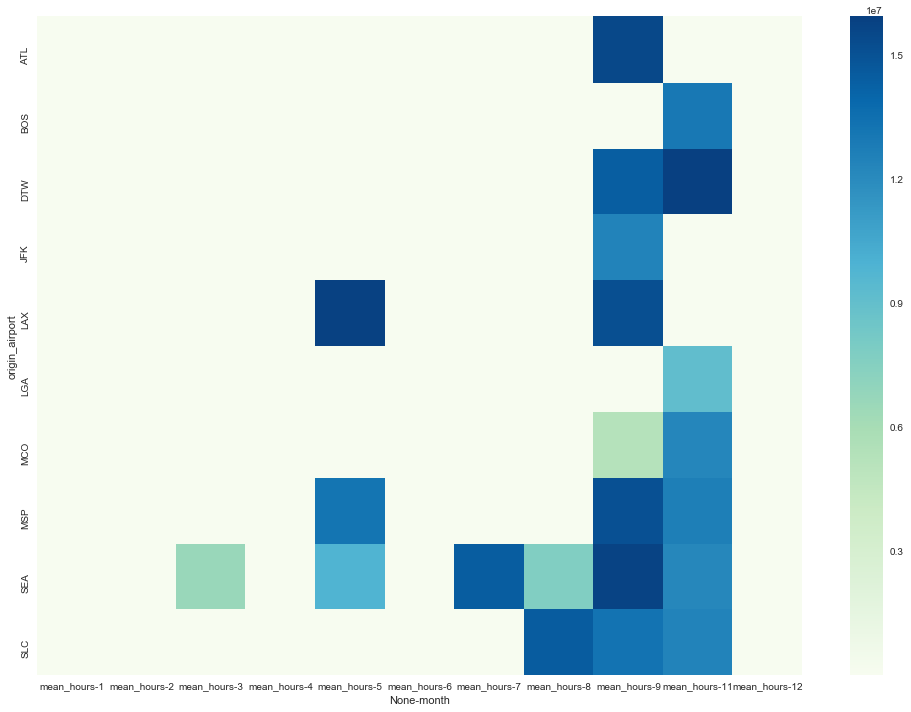

In [68]:
# Heatmap of data
plt.figure(figsize = (14, 10))
sns.heatmap(mean_times_month, cmap = 'GnBu')
plt.tight_layout();

The scale is too large to get a clear visual of the data-- take the log for better visualization.

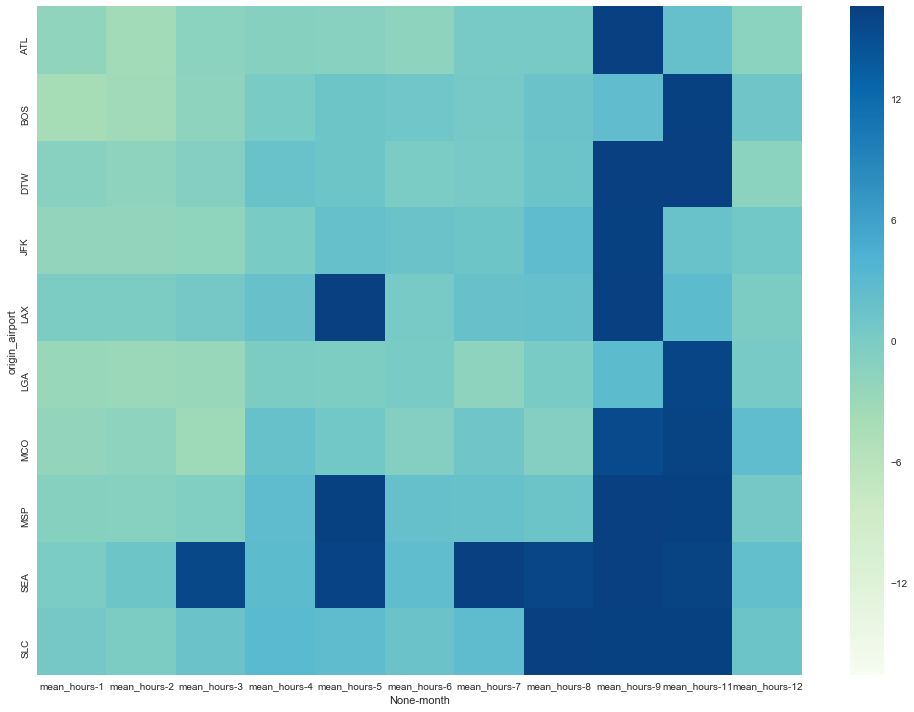

In [69]:
# Heatmap of log-transformed data
plt.figure(figsize = (14, 10))
sns.heatmap(np.log(mean_times_month), cmap = 'GnBu')
plt.tight_layout();

There is no data for October (Month 10), but the longest delays between cancellations tend to be in the Fall around September (Month 9) to November (Month 11). The shortest times between cancellations tend to be in the winter, and especially January (Month 1) to February (Month 2).

## 4. Model the time between cancellations as a Poisson distribution
- For the Delta Air data for BOS airport in month 5 (May), compute the probability of the expected time between cancellation exceeding 5.

In [70]:
u = mean_times_month.loc['BOS', ('mean_hours', 5)]
u

3.3124991718752068

In [71]:
# Poisson survival function -- equivalent to (1 - poisson.cdf)
st.poisson.sf(5, u), 1 - st.poisson.cdf(5, u)

(0.11863150038456677, 0.11863150038456682)

The probability of the expected time between cancellations exceeding 5 is less than 12%.

## 5. Is there a significant difference between the three most active airlines for overall cancellation rates?

In [72]:
top3_airlines = airline_stats.sort_values(by = 'flight_vol', ascending = False).index.values[:3]
top3_airlines

array(['WN', 'DL', 'AA'], dtype=object)

In [73]:
air_mask = flights.airline.isin(top3_airlines)
ctab = pd.crosstab(flights[air_mask].airline, flights[air_mask].cancelled)
ctab

cancelled,0,1
airline,,
AA,64088,10194
DL,79521,3807
WN,114520,15721


In [74]:
chi2, p, dof, expected = st.chi2_contingency(ctab)
print('p-value : {}'.format(p))
print('Expected :\n{}'.format(expected))

p-value : 0.0
Expected :
[[  66612.02628443    7669.97371557]
 [  74723.98328302    8604.01671698]
 [ 116792.99043255   13448.00956745]]


* p-value << 0.05; reject null hypothesis
* All had expected values > 5, so the Chi-square test is appropriate to use.
* Delta had significantly fewer cancellations, suggesting that the airlines have differences in their rates of cancellation.

## 6. Show the relationship between travel routes (origin -> destination) and diversion rates for Delta Air and the top 10 airports from earlier

In [75]:
airport_mask = delta_flights.origin_airport.isin(top10) & delta_flights.destination_airport.isin(top10)
diverted = delta_flights[airport_mask].groupby(['origin_airport', 'destination_airport']).diverted.mean().unstack()

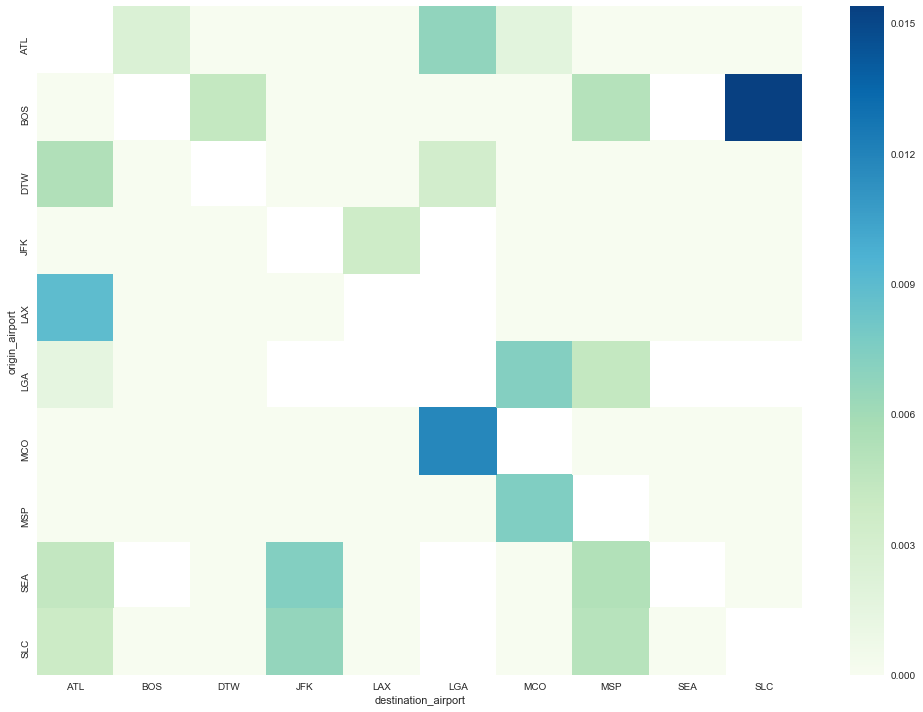

In [76]:
plt.figure(figsize = (14, 10))
sns.heatmap(diverted, cmap = 'GnBu')
plt.tight_layout();

* White cells indicate non-existent route (the cell is null).
* BOS -> SLC has a much higher diversion rate as compared with the other routes in this subset.

## 7. Create and fill a column for mean ground speed for every flight in miles/hour
- Do any of these seem unusual?
- (distance column is in miles)

In [77]:
hours = flights.air_time / 60
flights['ground_speed'] = flights.distance / hours

In [78]:
flights[['ground_speed', 'air_time']].describe(percentiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

,ground_speed,air_time
count,5.241410e+05,524141.000000
mean,inf,141.546807
std,NaN,202.911192
min,3.556810e+00,0.000000
5%,2.086957e+02,27.000000
10%,2.544000e+02,36.000000
25%,3.091011e+02,55.000000
50%,3.787500e+02,89.000000
75%,4.680000e+02,147.000000
90%,1.006588e+03,265.000000


* Ground speeds: Both Inf and 3.5mph are physically impossible flight speeds, so we know that those data are corrupted.
* Air time: The max air time of approximately 24hrs warrants further exploration, as this is an implausible result.
* Together, these results indicate that there are records which need to be explored for cleanup and further processing.

## 8. Create a visual for the mean times of delay reasons for each airline. Create one for delay proportions for each airline.

In [79]:
# List of delay reasons
delay_reasons = ['air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay']

# Group by airline and compute means for delay reasons
delay_means = flights.groupby('airline')[delay_reasons].mean()

# Create a new table containing proportions of total delay
delay_props = delay_means.div(delay_means.sum(axis = 1), axis = 'index')

## Visual for mean times

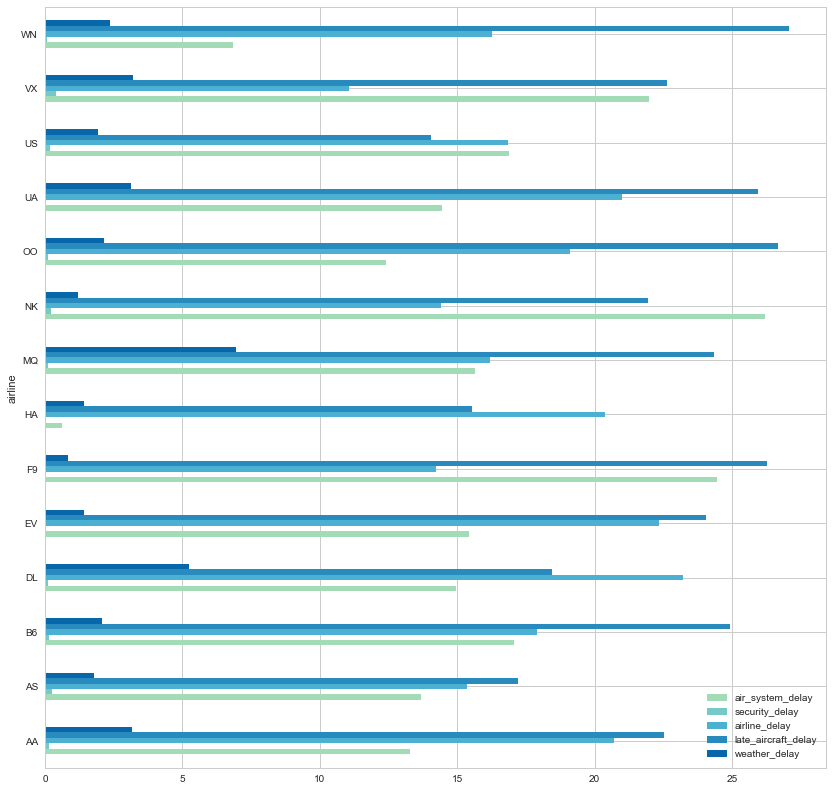

In [80]:
delay_means.plot.barh(color = gnbu[15::5], figsize = (14, 14));

## Visual for proportions

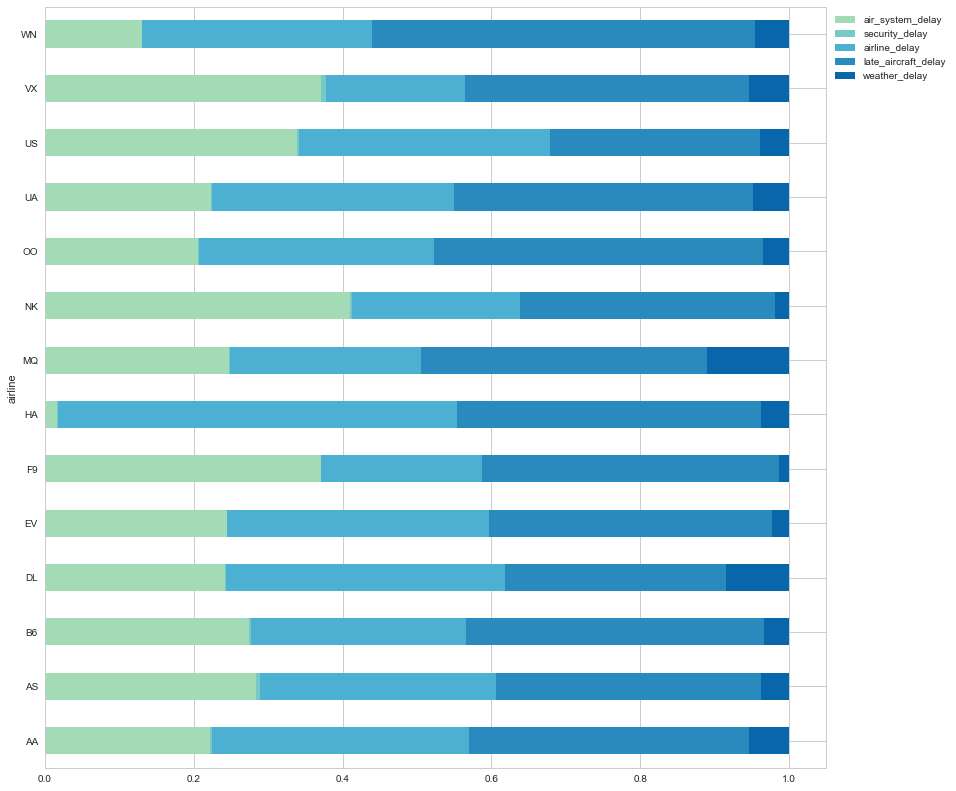

In [81]:
ax = delay_props.plot.barh(stacked = True, color = gnbu[15::5], figsize = (14, 14))
ax.legend(bbox_to_anchor = [1, 1]);

Hawaiian Airlines appears to have a very low paroportion of air system delays, but a very high proportion of airline delays.

## 9. Plot the delay reasons by airline using a parallel coordinates plot for the top 3 airlines
- this can take a while so use a random sample of 10% of the data

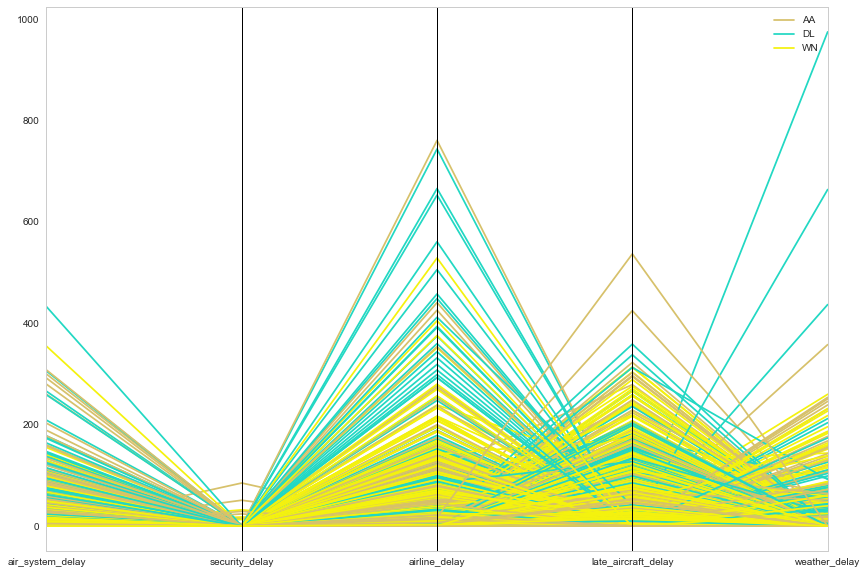

In [82]:
from pandas.plotting import parallel_coordinates

sample = flights[['airline'] + delay_reasons][flights.airline.isin(top3_airlines)].dropna().sample(frac = 0.1)
plt.figure(figsize = (14, 10))
parallel_coordinates(sample, 'airline');

No real clusters here, but this method can be useful for visualizing the relationship between multiple numeric features and a single categorical feature. The style works best with 2-5 levels in the categorical variable.

# EDA: Cycle Share

## Exponential distribution property

The exponential distribution has a special property that is referred to as the memoryless property. In terms of time, it states that the probability of an exponential random variable exceeding some value does not depend on how much time has already elapsed. Mathematically it looks like

$$P(X > s + t | X > t) = P(X > s)$$

Where $t$ is the amount of time already elapsed.

In [83]:
# Import data modules
import pandas as pd
from pandas import DataFrame as DF
from pandas import Series
import numpy as np

# Import stats modules
import scipy as scp
import scipy.stats as st

# Import plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting parameters
%matplotlib inline
sns.set_style('whitegrid')
gnbu = sns.color_palette('GnBu', 40)

In [84]:
# read data
trips = pd.read_csv('data/trip_cleaned.csv', parse_dates = ['starttime', 'stoptime'], dtype = {31 : str})
stations = pd.read_csv('data/station.csv', parse_dates = ['install_date', 'modification_date', 'decommission_date'])

In [85]:
trips.columns[31], trips.iloc[:, 31].dtype

('Events', dtype('O'))

In [86]:
trips.iloc[:, 31].astype(str).value_counts()

nan                    150239
Rain                    74888
Fog                      4402
Fog , Rain               1836
Fog-Rain                 1535
Rain , Thunderstorm      1355
Rain-Thunderstorm        1032
Snow                      463
Rain-Snow                 252
Rain , Snow                63
Name: Events, dtype: int64

In [87]:
def data_summary(data):
    # Show null counts
    print('Null counts')
    print(data.isnull().sum(), '\n\n', 50*'-', '\n\n')
    
    # Summaries for columns of numeric type
    print('Numeric description')
    print(data.describe().T, '\n\n', 50*'-', '\n\n')
    
    # Summaries for columns of 'object' type
    print('Categorical description')
    print(data.describe(include = ['O']).T, '\n\n', 50*'-', '\n\n')
    
    # Summaries for dates
    print('Datetime description')
    print(data.describe(include = ['datetime']))

In [88]:
data_summary(trips)

Null counts
trip_id                            0
starttime                          0
stoptime                           0
bikeid                             0
tripduration                       0
from_station_name                  0
to_station_name                    0
from_station_id                    0
to_station_id                      0
usertype                           0
gender                         89894
birthyear                      89898
Max_Temperature_F                  0
Mean_Temperature_F                 0
Min_TemperatureF                   0
Max_Dew_Point_F                    0
MeanDew_Point_F                    0
Min_Dewpoint_F                     0
Max_Humidity                       0
Mean_Humidity                      0
Min_Humidity                       0
Max_Sea_Level_Pressure_In          0
Mean_Sea_Level_Pressure_In         0
Min_Sea_Level_Pressure_In          0
Max_Visibility_Miles               0
Mean_Visibility_Miles              0
Min_Visibility_Miles      

## Time series

Pandas offers easy to use tools for working with time series. A couple of these tools include resampling the frequency (downsampling and upsampling), and easily plotting time series.

* Resampling
    - pandas has a `resample()` method that let's us easily downsample and upsample time series
    - downsampling is the process of reducing the frequency of a time series
        + an example of this is changing a time series from hourly to daily or weekly
        + anlalyze groups by day where individuals have different time stamps by time of day
    - upsampling is the opposite, where frequency is increased
        - this requires some form of interpolation
        - upsampling won't be used here
* Plotting
    - plotting time series data with pandas is as easy as all other plotting methods, only we need to set the time series of interest as the index (if it is currently a column).
    - we can use the `set_index()` method to do this.

## 1. Create a plot of min (blue dotted), max (red dotted), and mean (black) temperature over time.
* Give the plot a title, and name the x-axis "Date" and the y-axis "Temp (F)"

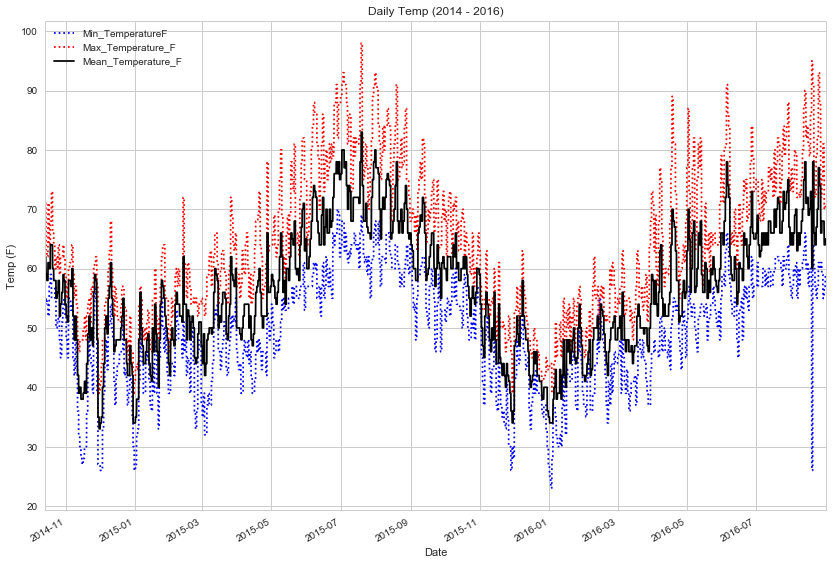

In [89]:
cols = ['starttime', 'Min_TemperatureF', 'Max_Temperature_F', 'Mean_Temperature_F']
temp = trips[cols].sort_values(by = 'starttime').set_index('starttime', drop = True)

ax = temp.plot(style = ['b:', 'r:', 'k'], figsize = (14, 10))
ax.set(title = 'Daily Temp (2014 - 2016)', xlabel = 'Date', ylabel = 'Temp (F)');

## 2. Resample the temperature data so that the series includes only one row per day (use the mean), and plot a rolling mean of this resampled data. Use a windows size of 7 days.

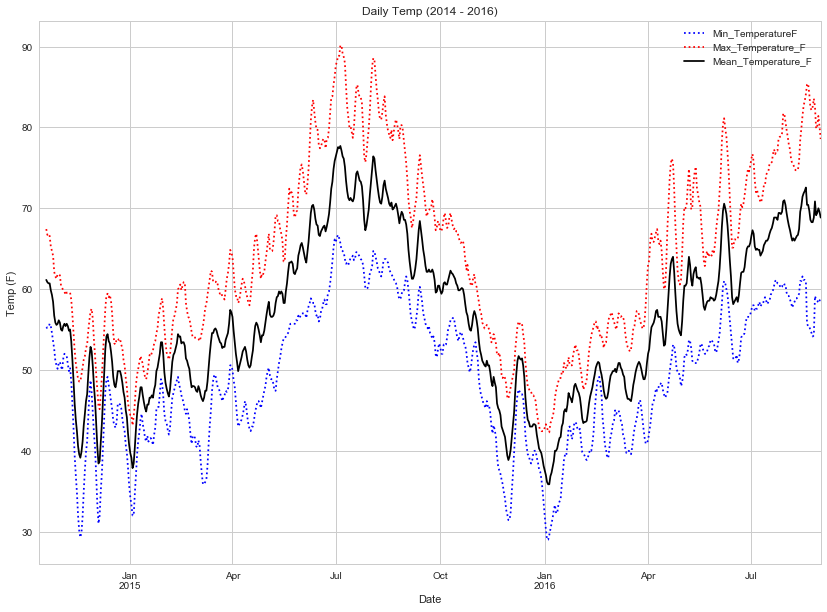

In [90]:
ax = temp.resample('D').mean().rolling(window = 7).mean().plot(style = ['b:', 'r:', 'k'], figsize = (14, 10))
ax.set(title = 'Daily Temp (2014 - 2016)', xlabel = 'Date', ylabel = 'Temp (F)');

## 3. Plot the average number of trips per hour for the month of July (this count will be for all stations)

In [91]:
times = pd.DatetimeIndex(trips.starttime)
hourly = trips.groupby([times.month, times.day, times.hour]).size().unstack(level = 1).mean(axis = 1)
hourly.index.rename(['month', 'hour'], level = [0, 1], inplace = True)

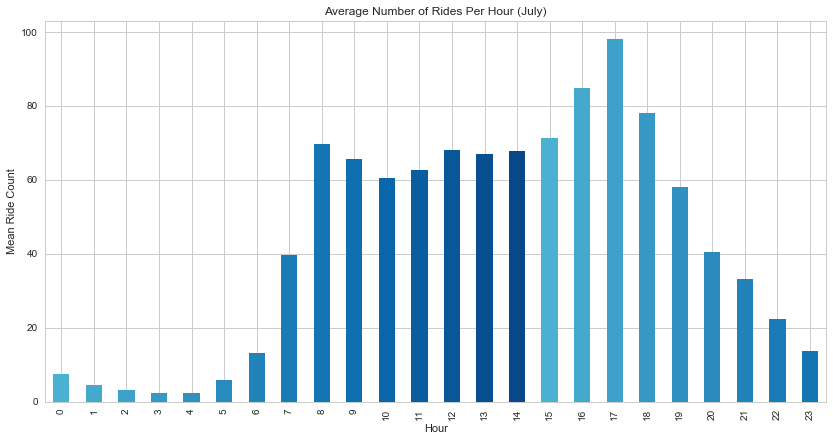

In [92]:
july = hourly.loc[(7, )]
ax = july.plot.bar(figsize = (14, 7), color = gnbu[25:])
ax.set(title = 'Average Number of Rides Per Hour (July)', xlabel = 'Hour', ylabel = 'Mean Ride Count');

## 4. Plot the average number of trips per hour, per station for the month of July.

In [93]:
hourly = trips.groupby(['from_station_name', times.month, times.day, times.hour]).size()\
    .unstack(level = 2).mean(axis = 1)
hourly.index.rename(['month', 'hour'], level = [1, 2], inplace = True)

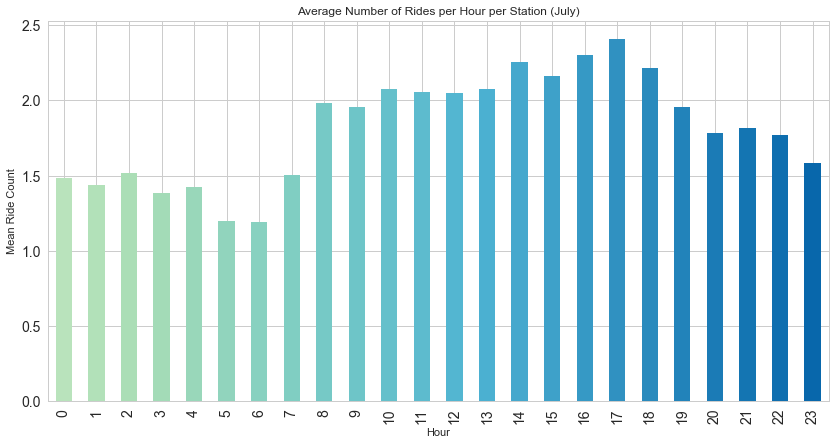

In [94]:
# Use the pandas IndexSlice to select only the month of July from multiindex
idx = pd.IndexSlice
july = hourly.loc[idx[:, 7, :]]

# Unstack and compute mean over stations, plot July data
ax = july.unstack().mean().plot.bar(figsize = (14, 7), color = gnbu[12:], fontsize = 14)
ax.set(title = 'Average Number of Rides per Hour per Station (July)', xlabel = 'Hour', ylabel = 'Mean Ride Count');

## 5. Show the distribution of trip durations for the month of May using a histogram with a KDE overlay.

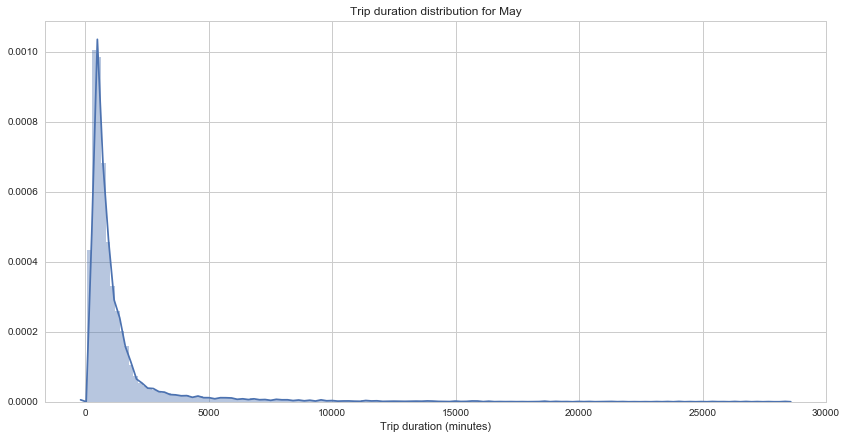

In [95]:
# Create a mask from previously created 'times' datetime index
mask = trips.starttime.isin(times[times.month == 5])
may_duration = trips[mask].tripduration
plt.figure(figsize = (14, 7))
ax = sns.distplot(may_duration, bins = 150)
ax.set(title = 'Trip duration distribution for May', xlabel = 'Trip duration (minutes)');

## 6. How would you describe this distribution? Determine the following
* What is the expected trip duration in May?
* For the month of May, what is the probability that an individual trip will last for at least 20 minutes?
* If this trip is currently at 14 minutes, what is the probability that it will last for at least another 20 minutes?
* If the trip is currently at 16 minutes, what is the probability that it will last at least a total of 20 minutes?

### Describe distribution
Extremely right-skewed (can be treated as exponential)

### Expected trip duration in May

In [96]:
# Expected trip duration in seconds
exp_seconds = may_duration.mean()
exp_seconds

1305.628519300941

In [97]:
# Expected trip duration in minutes
exp_minutes = exp_seconds / 60
exp_minutes

21.76047532168235

### P(X >= 20min)

In [98]:
# Compute lambda in minutes
lam = 1 / (may_duration.mean() / 60)

# cdf = 1 - exp(-lam * x)
# At least 20min : 1 - cdf = 1 - (1 - np.exp(-am*20)) = np.exp(-lam*20)
np.exp(-lam*20)

0.39887883876495456

### P(X >= 20 + t | X > t) where t = 14
Unchanged from previous: exponential distribution is 'memoryless', which means it doesn't matter how long it has been, the probability will be the same.

In [99]:
np.exp(-lam*20)

0.39887883876495456

### P(X >= 4 + t | X > t) where t = 6
Must compute $P(X > 4 + 16 | X > 16) = P(X > 4)$

In [100]:
np.exp(-lam*4)

0.83208597006828977

## 7. Use pandas to create side-by-side box plots for the trip durations for each station throughout the months of Jun, July, Aug.

[(0, 8000)]

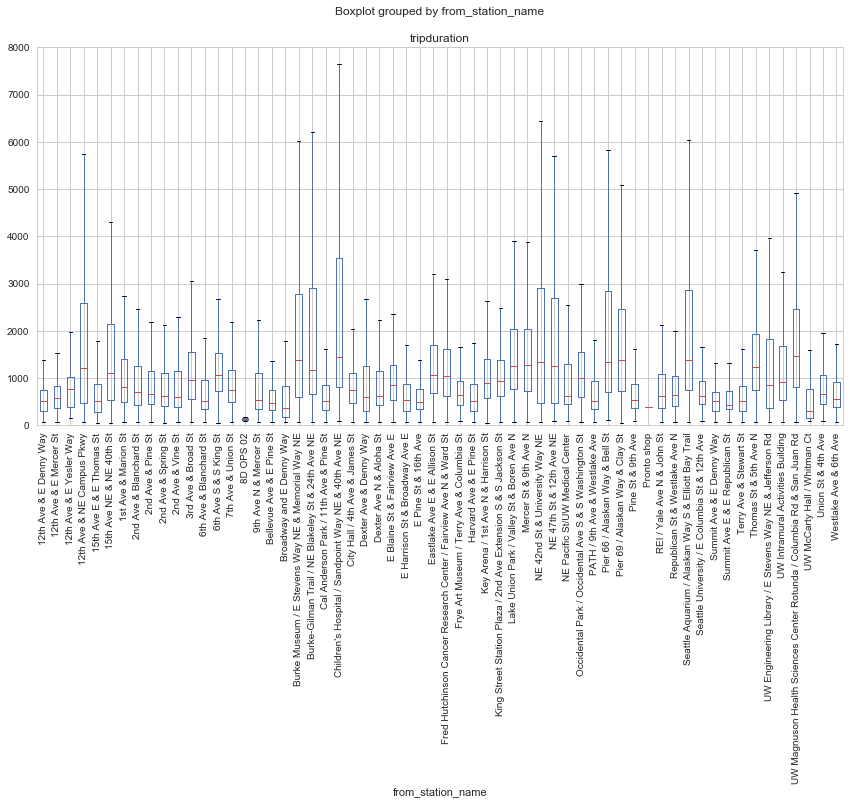

In [101]:
trips_cpy = trips.copy()
trips_cpy['month'] = trips_cpy.starttime.apply(lambda x: x.month)

ax = trips_cpy[trips_cpy.month.isin([6, 7, 8])].boxplot(column = 'tripduration', by = 'from_station_name',
                                                        figsize = (14, 7), rot = 90)
ax.set(ylim = [0, 8000])

## 8. Use split violin plots to show the differences between usertype for the distributions of tripduration for each year

In [102]:
trips.usertype.unique()

array(['Member', 'Short-Term Pass Holder'], dtype=object)

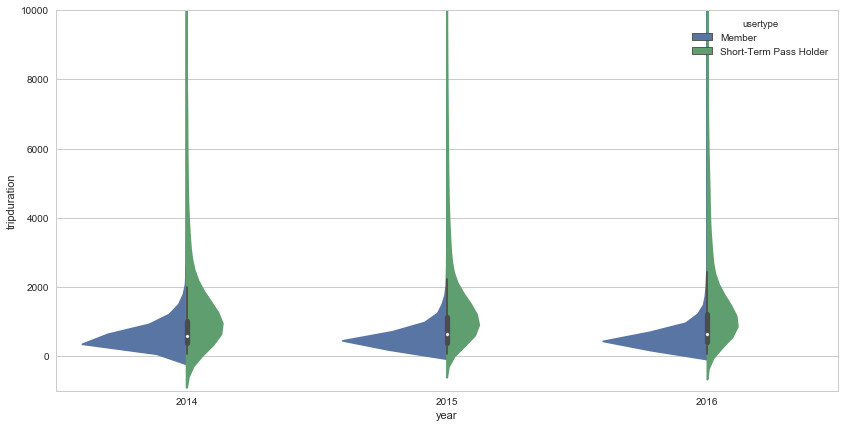

In [103]:
trips_cpy['year'] = trips_cpy.starttime.apply(lambda x: x.year)
plt.figure(figsize = (14, 7))
ax = sns.violinplot(x = trips_cpy.year, y = trips_cpy.tripduration, hue = trips_cpy.usertype, split = True)
ax.set(ylim = [-1000, 10000]);

Short-term pass holders appear more likely to take longer bike trips, with wider variance in length of trip. Members have a much more normal distribution with overall shorter trips and smaller variance, suggesting regular routes such as for commutes.

Note: Negative duration values occur due to distribution estimation, not to erroneous negative duration values. This can be seen by reducing the bw (bandwidth) parameter to reduce smoothing.

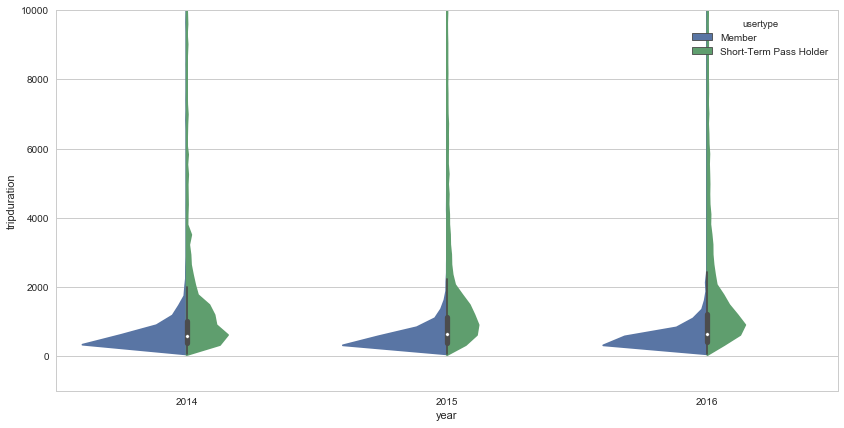

In [104]:
plt.figure(figsize = (14, 7))
ax = sns.violinplot(x = trips_cpy.year, y = trips_cpy.tripduration, hue = trips_cpy.usertype, split = True, bw = 0.005)
ax.set(ylim = [-1000, 10000]);

## 9. Show precipitation and humidity over the course of 2016 in one figure.

Since the scale for precipitation is much smaller than that for humidity, we will need two y-axis scales/labels. This can be accomplished using Pandas secondary_y parameter.

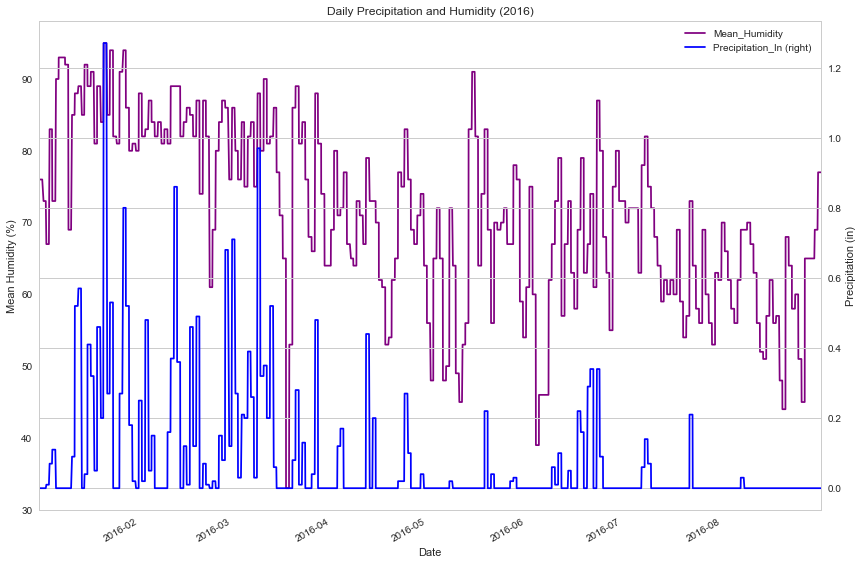

In [105]:
cols = ['starttime', 'Precipitation_In', 'Mean_Humidity']
trips16 = trips_cpy[trips_cpy.year == 2016]
temp = trips16[cols].sort_values(by = 'starttime').set_index('starttime', drop = True)

ax = temp.Mean_Humidity.plot(style = ['purple'], figsize = (14, 10), legend = True)
temp.Precipitation_In.plot(style = ['b'], ax = ax, secondary_y = True, legend = True)
ax.set(title = 'Daily Precipitation and Humidity (2016)', xlabel = 'Date', ylabel = 'Mean Humidity (%)')
ax.right_ax.set(ylabel = 'Precipitation (in)');